# Double Machine Learning meets Panel Data - Promises, Pitfalls, and Potential Solutions
by Jonathan Fuhr and Dominik Papies

Abstract
Estimating causal effect using machine learning (ML) algorithms can help to relax functional
form assumptions if used within appropriate frameworks. However, most of these frameworks
assume settings with cross-sectional data, whereas researchers often have access to panel data,
which in traditional methods helps to deal with unobserved heterogeneity between units. In this
paper, we explore how we can adapt double/debiased machine learning (DML) (Chernozhukov
et al., 2018) for panel data in the presence of unobserved heterogeneity. This adaptation is challenging
because DML’s cross-fitting procedure assumes independent data and the unobserved
heterogeneity is not necessarily additively separable in settings with nonlinear observed confounding.
We assess the performance of several intuitively appealing estimators in a variety of
simulations. While we find violations of the cross-fitting assumptions to be largely inconsequential
for the accuracy of the effect estimates, many of the considered methods fail to adequately
account for the presence of unobserved heterogeneity. However, we find that using predictive
models based on the correlated random effects approach (Mundlak, 1978) within DML leads to
accurate coefficient estimates across settings, given a sample size that is large relative to the
number of observed confounders. We also show that the influence of the unobserved heterogeneity
on the observed confounders plays a significant role for the performance of most alternative
methods.

# Simulation Study with DoubleML and Panel Data

## DGP

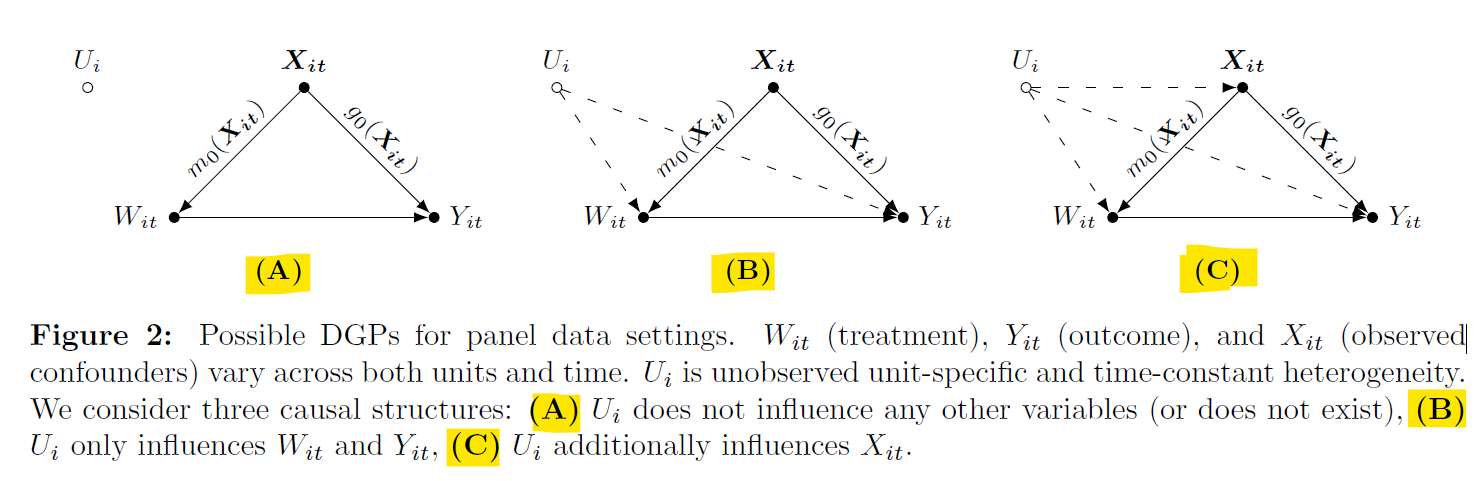

In [1]:
import numpy as np
import pandas as pd

def generate_data(
    N=100,
    T=50,
    unobserved_heterogeneity=False,
    unobserved_heterogeneity_on_covariates=False,
    nonlinear=False,
    autocorrelation=0.0,
    seed=42
):
    """
    Generates panel data for simulation.

    Parameters:
    - N: Number of units
    - T: Number of periods
    - unobserved_heterogeneity: If True, introduces unit-specific unobserved heterogeneity
    - nonlinear: If True, introduces non-linear confounding
    - autocorrelation: AR(1) coefficient for serially correlated errors in outcome
    - seed: Random seed for reproducibility

    Returns:
    - DataFrame containing the generated panel data with columns ['unit', 'time', 'Y', 'W', 'X', 'U']
    """
    np.random.seed(seed)
    alpha = np.random.normal(0, 1, 3)
    beta = 1.0
    gamma = np.random.normal(0, 1, 1)
    delta = np.random.normal(0, 1, 1)

    # Generate unobserved heterogeneity (unit-specific)
    U = np.random.normal(0, 1, N) if unobserved_heterogeneity else np.zeros(N)

    # Generate observed confounders (time-varying)
    X = alpha[0] + np.random.normal(0, 1, (N, T))
    if unobserved_heterogeneity_on_covariates:
        X += delta * U[:, None]
    if nonlinear:
        X = X ** 2

    # Generate treatment variable
    W = alpha[1] + gamma * X + delta * U[:, None] + np.random.normal(0, 1, (N, T))

    # Generate outcome variable with AR(1) process for error
    errors = np.random.normal(0, 1, (N, T))
    Y = np.zeros((N, T))
    Y[:, 0] = alpha[2] + beta * W[:, 0] + gamma * X[:, 0] + delta * U + errors[:, 0]
    for t in range(1, T):
        Y[:, t] = (
            alpha[2] + beta * W[:, t] + gamma * X[:, t] + delta * U +
            autocorrelation * errors[:, t - 1] + errors[:, t]
        )

    # Reshape and return as a DataFrame
    data = pd.DataFrame({
        'unit': np.repeat(np.arange(N), T),
        'time': np.tile(np.arange(T), N),
        'Y': Y.flatten(),
        'W': W.flatten(),
        'X': X.flatten(),
        'U': np.repeat(U, T)  # Unobserved heterogeneity for validation only
    })
    return data


In [2]:
N = 100
T = 50
n_runs = 100

## Oracle

In [3]:
import statsmodels.api as sm

def estimate_effect(data):
    model = sm.OLS(data['Y'], sm.add_constant(data[['W', 'X', 'U']]))
    result = model.fit()
    return result.params['W']

In [4]:
oracle_results = []
for _ in range(100):
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N,
        T=T, 
        unobserved_heterogeneity=False,
        unobserved_heterogeneity_on_covariates=False,
        nonlinear=True, 
        autocorrelation=0.9,
        seed=seed
        )
    oracle_results.append(estimate_effect(data))

In [5]:
results_df_or = pd.DataFrame({"Oracle": oracle_results})
results_df_or.mean()

Oracle    1.002121
dtype: float64

C:\Users\Work\AppData\Local\Temp\ipykernel_47392\1933644194.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


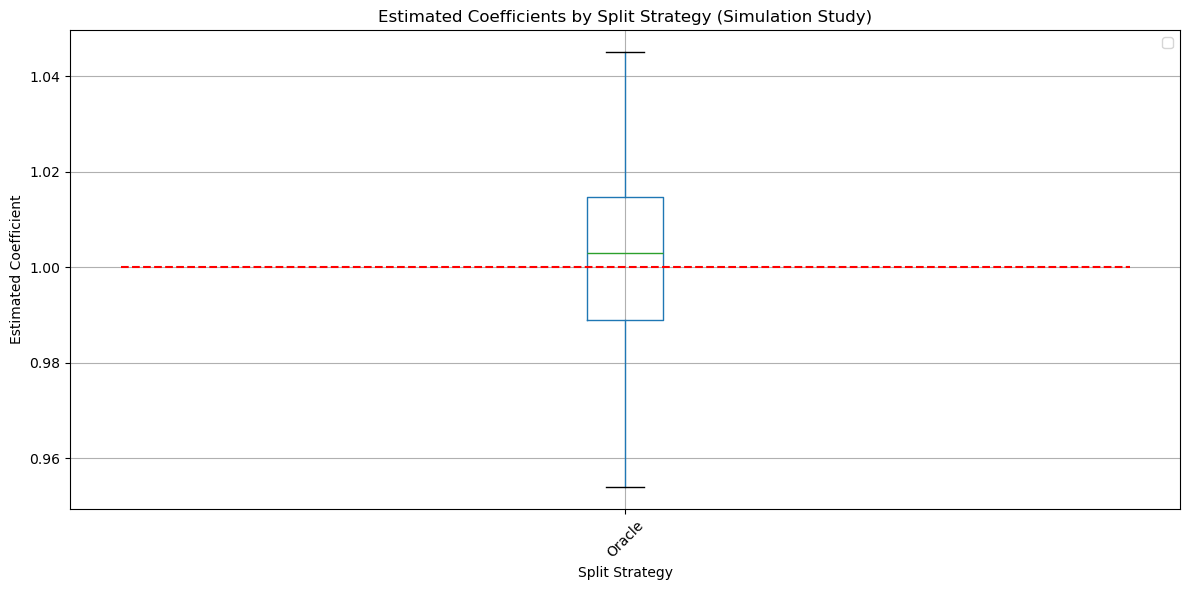

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
results_df_or.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.xticks(rotation=45)
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=2)
plt.legend()
plt.tight_layout()
plt.show()

# Simulation Results

In [7]:
split_strategies = ["random", "by_time", "by_unit", "time_adjacent", "neighbors_left_out"]
results = {strategy: [] for strategy in split_strategies}

## Standard-DML

In [8]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLPLR, DoubleMLData


for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N,
        T=T,
        unobserved_heterogeneity=False,
        unobserved_heterogeneity_on_covariates=False,
        nonlinear=True,
        autocorrelation=0.9,
        seed=seed
        )
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        data,
        y_col='Y',
        d_cols='W',
        x_cols=['X'],
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [9]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.045331
by_time               1.041811
by_unit               1.042866
time_adjacent         1.042763
neighbors_left_out    1.051792
dtype: float64

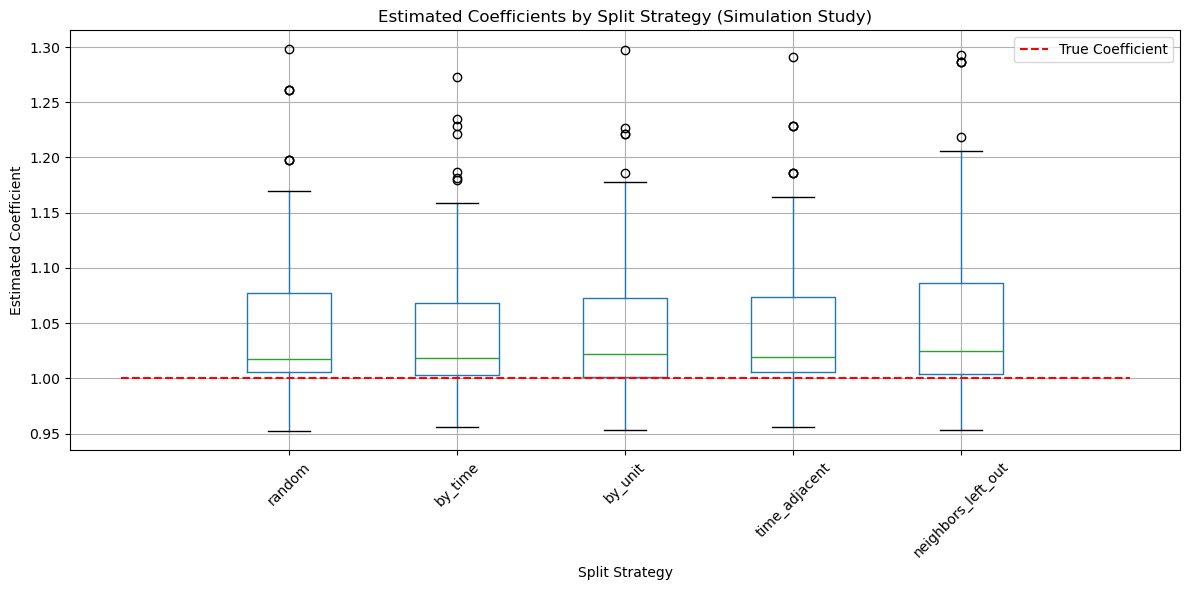

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Dummy-DML

In [11]:
for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N, 
        T=T, 
        unobserved_heterogeneity=False,
        unobserved_heterogeneity_on_covariates=False,
        nonlinear=True, 
        autocorrelation=0.9,
        seed=seed
        )
    unit_dummies = pd.get_dummies(data["unit"], drop_first=False)
    unit_dummy_cols = list(unit_dummies.columns)
    dummy_data = pd.concat([data, unit_dummies], axis=1)
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        dummy_data, 
        y_col='Y',
        d_cols='W', 
        x_cols=['X'] + unit_dummy_cols, 
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [12]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.048471
by_time               1.044158
by_unit               1.046638
time_adjacent         1.044857
neighbors_left_out    1.055781
dtype: float64

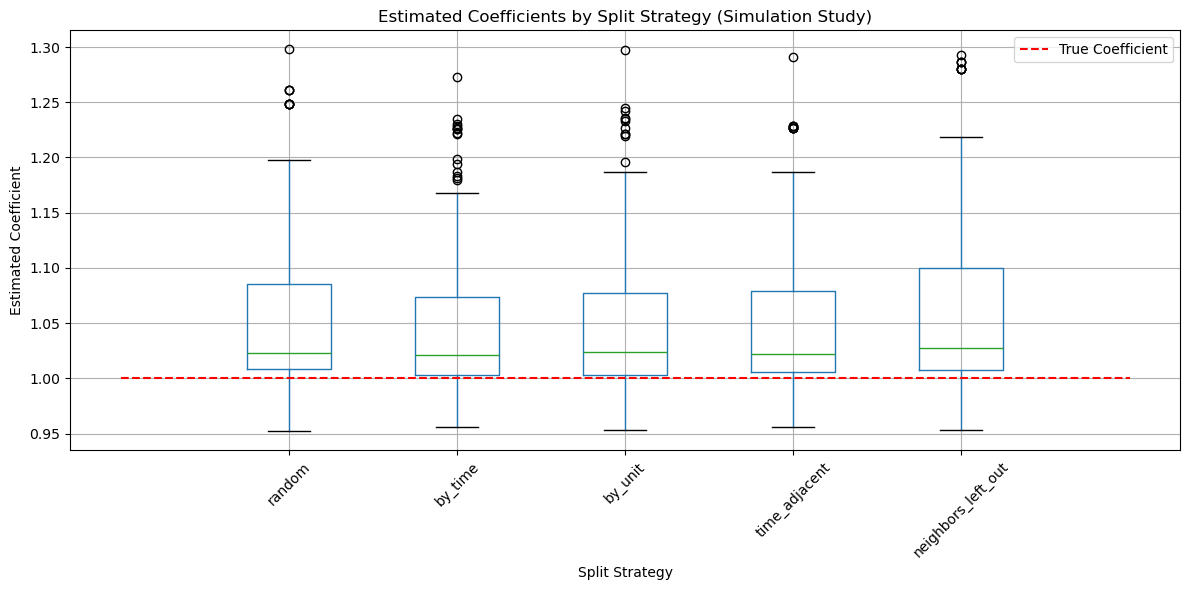

In [13]:
plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Early-Demeaned-DML

In [14]:
for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N, 
        T=T, 
        unobserved_heterogeneity=False,
        unobserved_heterogeneity_on_covariates=False,
        nonlinear=True, 
        autocorrelation=0.9,
        seed=seed
    )

    data['Y'] = data['Y'] - data.groupby('unit')['Y'].transform('mean')
    data['X'] = data['X'] - data.groupby('unit')['X'].transform('mean')
    data['W'] = data['W'] - data.groupby('unit')['W'].transform('mean')
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        data,
        y_col='Y',
        d_cols='W', 
        x_cols=['X'], 
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [15]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.048779
by_time               1.045462
by_unit               1.047386
time_adjacent         1.045740
neighbors_left_out    1.056634
dtype: float64

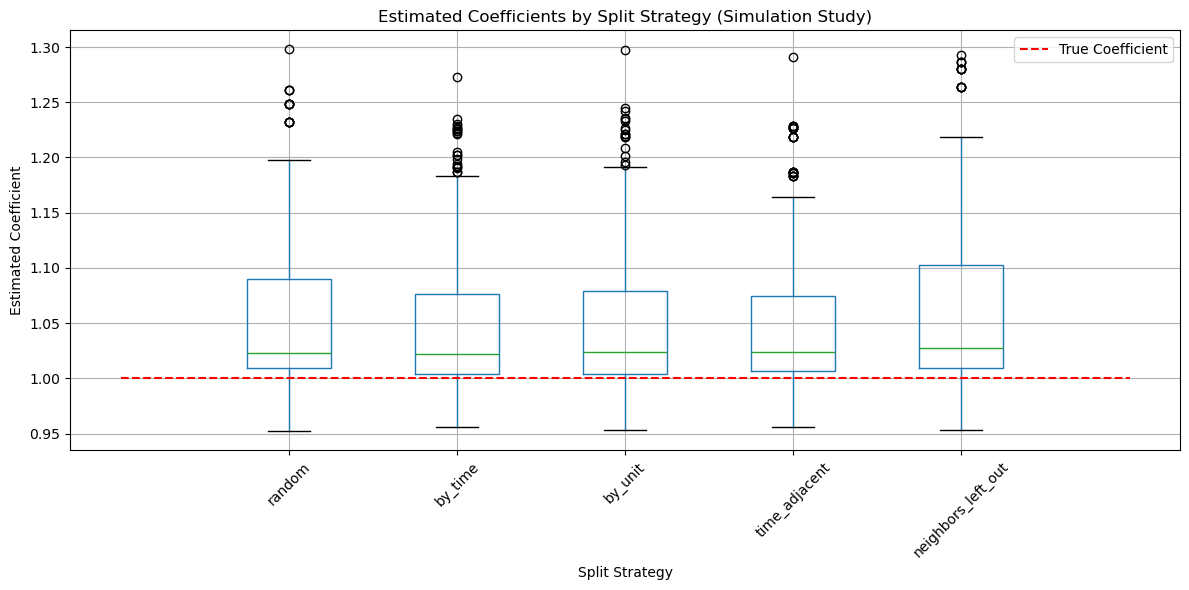

In [16]:
plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## CRE?

In [17]:
for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N,
        T=T, 
        unobserved_heterogeneity=True,
        unobserved_heterogeneity_on_covariates=False,
        nonlinear=True, 
        autocorrelation=0.2,
        seed=seed
    )

    X_mean = data.groupby("unit")["X"].transform("mean")
    W_mean = data.groupby("unit")["W"].transform("mean")

    data['X_mean'] = X_mean
    data['W_mean'] = W_mean
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        data,
        y_col='Y',
        d_cols='W', 
        x_cols=['X' , 'X_mean', 'W_mean'], 
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [18]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.044929
by_time               1.042158
by_unit               1.047550
time_adjacent         1.041995
neighbors_left_out    1.051401
dtype: float64

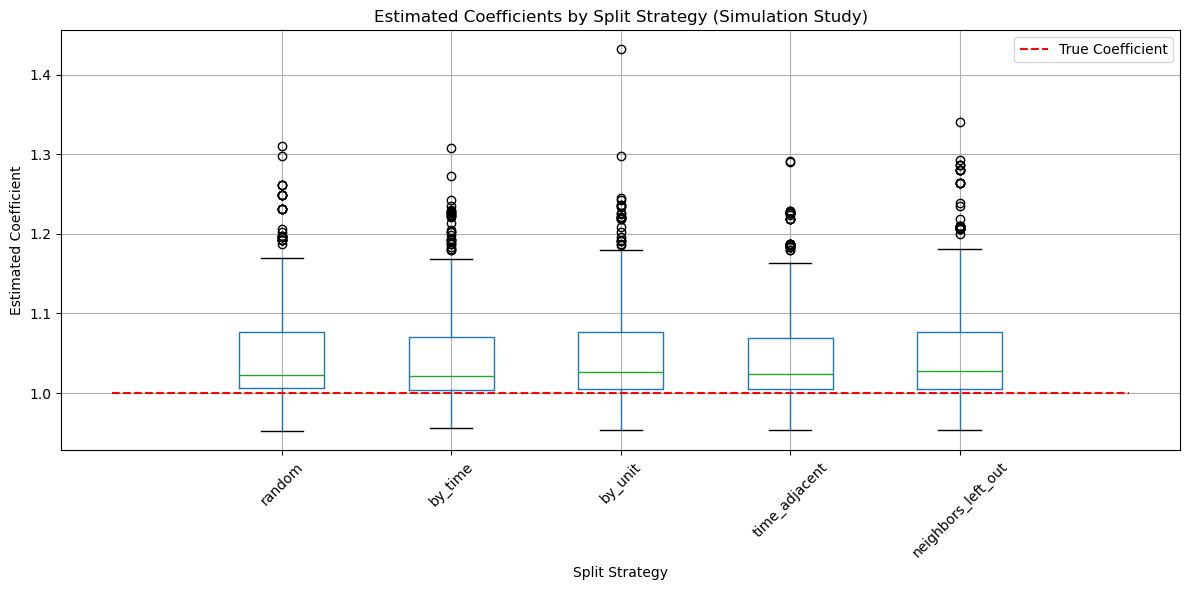

In [19]:
plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()